In [29]:
import os
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# set names to the paths because they're too long
data_path = 'D:\\Subjects_In_University\\Machine_Learning\\data\\Prac4'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [30]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    
    labels = np.zeros((real_num)).astype(np.int64)
    
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    
    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
    
        images = images[rand_id, :]
        labels = labels[rand_id,]
    
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [31]:
train_images, train_labels = get_mnist_data(
    train_images_path, train_labels_path, 5000, shuffle=True)

test_images, test_labels = get_mnist_data(
    test_images_path, test_labels_path, 10000, _is=False, shuffle=True)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(5000, 784) (5000,)
(10000, 784) (10000,)


In [32]:
# Convert matrix to image
def get_image(image):
    return image.reshape(28, 28)

# These methods are from Vi du 1
def convert_labels(y, C):
    from scipy import sparse
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [33]:
def _softmax_regression(X, Y, theta, lambda_=0.5, iterations=20, learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss
    
    losses = []
    _theta = theta
    d, N = X.shape
    
    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losses.append(log_loss(Y, Y_hat))
                
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")

    return _theta, losses

0 1


<Figure size 640x480 with 0 Axes>

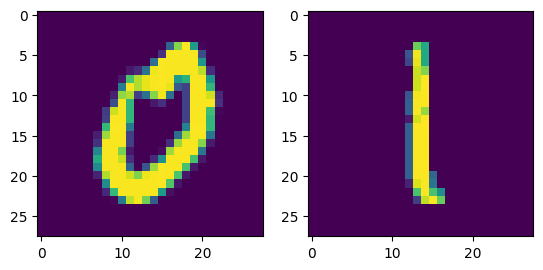

In [34]:
# for display and test digit :D
import random
import matplotlib.pyplot as plt

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])

train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

In [35]:
X_train = np.concatenate((np.ones((1, train_images.shape[0])), train_images.T), axis = 0)

Y_train = convert_labels(train_labels, 10)

(785, 5000)
(10, 5000)


<Figure size 640x480 with 0 Axes>

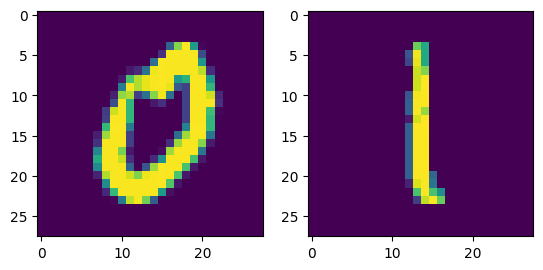

In [36]:
print(X_train.shape)
print(Y_train.shape)

train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

In [37]:
theta = np.zeros((X_train.shape[0], 10))

opt_theta, losses = _softmax_regression(X_train, Y_train, theta)
print('training success: ', opt_theta.shape, len(losses))

epoch 0 - cost 0.043269309535052904
epoch 1 - cost 0.01594883787498989
epoch 2 - cost 0.01011361267410292
epoch 3 - cost 0.008650476813388137
epoch 4 - cost 0.008667219340702989
epoch 5 - cost 0.010099129248732049
epoch 6 - cost 0.005046289793581242
epoch 7 - cost 0.005046111474476422
epoch 8 - cost 0.006487857610041108
epoch 9 - cost 0.0050573143075281135
epoch 10 - cost 0.0036043653389117368
epoch 11 - cost 0.00432523840669408
epoch 12 - cost 0.0029438526316059514
epoch 13 - cost 0.004325238406694079
epoch 14 - cost 0.0036043653389117368
epoch 15 - cost 0.0036043653389117368
epoch 16 - cost 0.0036043653389117368
epoch 17 - cost 0.0021626192033470507
epoch 18 - cost 0.000720873067782365
epoch 19 - cost 0.0014417461355647082
training success:  (785, 10) 500


In [38]:
from sklearn.metrics import accuracy_score
print('accuracy training data: ', accuracy_score(train_labels, pred(opt_theta, X_train)))

# test_images, test_labels = get_mnist_data(
# test_images_path, test_labels_path, 1000, _is=False, shuffle=False)

X_test = np.concatenate((np.ones((1, test_images.shape[0])), test_images.T), axis = 0)

print(X_test.shape)
print('accuracy testing data: ', accuracy_score(test_labels, pred(opt_theta, X_test)))

accuracy training data:  0.9378
(785, 10000)
accuracy testing data:  0.8632


In [51]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pca = PCA(n_components=2)
X_train_n = pca.fit_transform(train_images)
X_test_n = pca.fit_transform(test_images)

In [52]:
logR = LogisticRegression(multi_class='multinomial', solver='sag')
logR.fit(X_train_n, train_labels)

LogisticRegression(multi_class='multinomial', solver='sag')

In [53]:
y_pred = logR.predict(X_test_n)
y_pred

print(accuracy_score(test_labels, y_pred))

0.3587
